# CNN for NLP Classification
Reference Docs:
- https://chriskhanhtran.github.io/posts/cnn-sentence-classification/
- https://colab.research.google.com/drive/1b7aZamr065WPuLpq9C4RU6irB59gbX_K

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import nltk
nltk.download("all")
import torch
from models.cnn_nlp import CNN_NLP
%matplotlib inline

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/mike/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /home/mike/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/mike/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/mike/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/mike/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package ave

### Download Data

In [2]:
URL = 'https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'
# Download Datasets
!wget -P 'Data/' $URL
# Unzip
!tar xvzf 'Data/rt-polaritydata.tar.gz' -C 'Data/'

--2024-12-28 17:47:58--  https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.53
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487770 (476K) [application/x-gzip]
Saving to: ‘Data/rt-polaritydata.tar.gz.7’

rt-polaritydata.tar 100%[===================>] 476.34K  --.-KB/s    in 0.1s    

2024-12-28 17:47:58 (3.16 MB/s) - ‘Data/rt-polaritydata.tar.gz.7’ saved [487770/487770]

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


### Load text and labels
- texts will be numpy array of np_strs containing texts from both classes
- labels will be numpy array of np_int64s containing labels coded as integers

In [3]:
def load_text(path):
    """Load text data, lowercase text and save to a list."""
    with open(path, 'rb') as f:
        texts = []
        for line in f:
            texts.append(line.decode(errors='ignore').lower().strip())

    return texts

# Load files
neg_text = load_text('Data/rt-polaritydata/rt-polarity.neg')
pos_text = load_text('Data/rt-polaritydata/rt-polarity.pos')

# Concatenate and label data
texts = np.array(neg_text + pos_text)
labels = np.array([0]*len(neg_text) + [1]*len(pos_text))

### Download FastText

In [4]:
%%time
URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
FILE = "fastText"

if os.path.isdir(FILE):
    print("fastText exists.")
else:
    !wget -P $FILE $URL
    !unzip $FILE/crawl-300d-2M.vec.zip -d $FILE

fastText exists.
CPU times: user 91 μs, sys: 0 ns, total: 91 μs
Wall time: 84.2 μs


### Set Up GPU

In [5]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 4090


### Tokenize

In [6]:
from nltk.tokenize import word_tokenize
from collections import defaultdict

def tokenize(texts):
    """Tokenize texts, build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[str]): List of text data
    
    Returns:
        tokenized_texts (List[List[str]]): List of list of tokens
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    tokenized_texts = []
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)

        # Add `tokenized_sent` to `tokenized_texts`
        tokenized_texts.append(tokenized_sent)

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return tokenized_texts, word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tokenized_texts:
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

In [7]:
from tqdm import tqdm

def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin, total=n):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

### Execute above functions

In [8]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
tokenized_texts, word2idx, max_len = tokenize(texts)
input_ids = encode(tokenized_texts, word2idx, max_len)
# Load pretrained vectors
embeddings = load_pretrained_vectors(word2idx, "fastText/crawl-300d-2M.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


100%|██████████| 1999995/1999995 [00:16<00:00, 120408.98it/s]

There are 18522 / 20280 pretrained vectors found.


### Create Dataloaders

In [9]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,
                              SequentialSampler)

def data_loader(train_inputs, val_inputs, train_labels, val_labels,
                batch_size=50):
    """Convert train and validation sets to torch.Tensors and load them to
    DataLoader.
    """

    # Convert data type to torch.Tensor
    train_inputs, val_inputs, train_labels, val_labels =\
    tuple(torch.tensor(data) for data in
          [train_inputs, val_inputs, train_labels, val_labels])

    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    return train_dataloader, val_dataloader

In [10]:
from sklearn.model_selection import train_test_split

# Train Test Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.1, random_state=42)

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader = \
data_loader(train_inputs, val_inputs, train_labels, val_labels, batch_size=50)

### Function to intialize model and optimizer

In [11]:
import torch.optim as optim

def initilize_model(pretrained_embedding=None,
                    freeze_embedding=False,
                    vocab_size=None,
                    embed_dim=300,
                    filter_sizes=[3, 4, 5],
                    num_filters=[100, 100, 100],
                    num_classes=2,
                    dropout=0.5,
                    learning_rate=0.01):
    """Instantiate a CNN model and an optimizer."""

    assert (len(filter_sizes) == len(num_filters)), "filter_sizes and \
    num_filters need to be of the same length."

    # Instantiate CNN model
    cnn_model = CNN_NLP(pretrained_embedding=pretrained_embedding,
                        freeze_embedding=freeze_embedding,
                        vocab_size=vocab_size,
                        embed_dim=embed_dim,
                        filter_sizes=filter_sizes,
                        num_filters=num_filters,
                        num_classes=2,
                        dropout=0.5)
    
    # Send model to `device` (GPU/CPU)
    cnn_model.to(device)

    # Instantiate Adadelta optimizer
    optimizer = optim.Adadelta(cnn_model.parameters(),
                               lr=learning_rate,
                               rho=0.95)

    return cnn_model, optimizer

### Train Loop

/home/mike/projects/GIMC/env/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 001/020 | Train: 80.00% | Validation: 77.04%| Elapsed: 0.01 min
Epoch: 002/020 | Train: 83.19% | Validation: 77.51%| Elapsed: 0.03 min
Epoch: 003/020 | Train: 87.40% | Validation: 80.69%| Elapsed: 0.04 min
Epoch: 004/020 | Train: 92.56% | Validation: 82.38%| Elapsed: 0.05 min
Epoch: 005/020 | Train: 95.50% | Validation: 82.47%| Elapsed: 0.06 min
Epoch: 006/020 | Train: 97.54% | Validation: 83.04%| Elapsed: 0.08 min
Epoch: 007/020 | Train: 98.97% | Validation: 82.57%| Elapsed: 0.09 min
Epoch: 008/020 | Train: 98.37% | Validation: 81.26%| Elapsed: 0.10 min
Epoch: 009/020 | Train: 99.74% | Validation: 82.57%| Elapsed: 0.11 min
Epoch: 010/020 | Train: 99.79% | Validation: 82.76%| Elapsed: 0.13 min
Epoch: 011/020 | Train: 99.90% | Validation: 82.38%| Elapsed: 0.14 min
Epoch: 012/020 | Train: 99.93% | Validation: 82.47%| Elapsed: 0.15 min
Epoch: 013/020 | Train: 99.97% | Validation: 82.66%| Elapsed: 0.16 min
Epoch: 014/020 | Train: 99.98% | Validation: 83.41%| Elapsed: 0.18 min
Epoch:

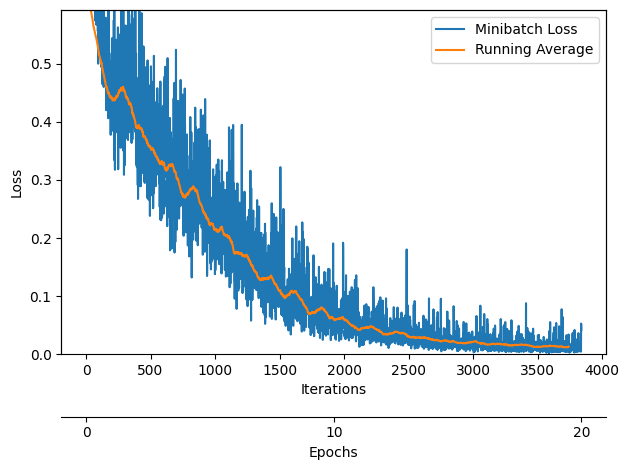

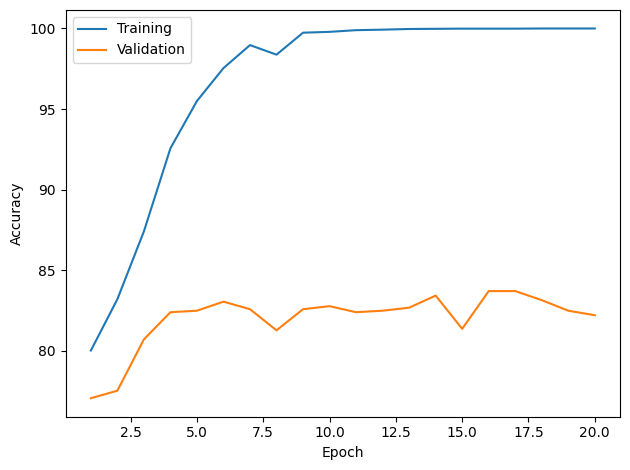

In [12]:
from utils.train import train_model
from utils.plot import plot_accuracy, plot_training_loss

LEARNING_RATE = 0.005
NUM_EPOCHS = 20
model, optimizer = initilize_model(pretrained_embedding=embeddings,
                                            freeze_embedding=False,
                                            learning_rate=0.25,
                                            dropout=0.5)
model = model.to(device)
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_dataloader,
    valid_loader=val_dataloader,
    test_loader=None,
    optimizer=optimizer,
    device=torch.device("cuda"),
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataloader),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

### Prediction Fuction

In [15]:
import torch.nn.functional as F
def predict(text, model=model.to("cpu"), max_len=62):
    """Predict probability that a review is positive."""

    # Tokenize, pad and encode text
    tokens = word_tokenize(text.lower())
    padded_tokens = tokens + ['<pad>'] * (max_len - len(tokens))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in padded_tokens]

    # Convert to PyTorch tensors
    input_id = torch.tensor(input_id).unsqueeze(dim=0)

    # Compute logits
    logits = model.forward(input_id)

    #  Compute probability
    probs = F.softmax(logits, dim=1).squeeze(dim=0)

    print(f"This review is {probs[1] * 100:.2f}% positive.")

In [19]:
predict("This movie is terrible but I did laugh a few time.")
predict("This movie is great but I was a bit confused in the second act. Great performances though. Overall, I enjoyed it, kinda.")

This review is 0.27% positive.
This review is 85.59% positive.
